# Analysis of performance of different ML models in text recognition task

In this project we'll apply scikit-learn library's classification models for the text recognition task. Specifically, we'll work with handwritten digits. 

As a dataset, we'll use [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI that is pre-loaded with the scikit-learn library. The library contains 8x8 images.

## Loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits

Let's load some images of digits from a scikit-learn library.

In [2]:
pictures = load_digits()
pictures.keys()

dict_keys(['target', 'target_names', 'DESCR', 'images', 'data'])

The images are stored as arrays: 2d arays under 'images' key and 1d arrays in 'data'. Let's check.

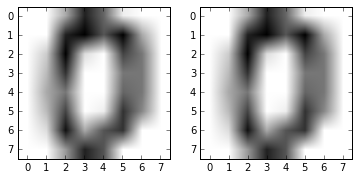

Label 0


In [3]:
fig,axs = plt.subplots(ncols = 2)
first_image = pictures['images'][0]
first_image2 = np.reshape(pictures['data'][0], (8,8))
axs[0].imshow(first_image, cmap='gray_r')
axs[1].imshow(first_image2, cmap='gray_r')
plt.show()
print('Label', pictures['target'][0])

Looks like everyhing should be correct. Let's select random numbers.

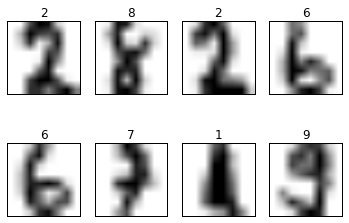

In [4]:
df = pd.DataFrame(pictures['data'])
df['label'] = pictures['target']

n_samples = 8
sample = df.sample(n_samples, random_state = 0)

fig,axs = plt.subplots(nrows = 2, ncols = 4)
n_samples = 8
for i in range(n_samples):
    s = sample.iloc[i]
    label = s['label']
    r = s.drop('label')
    img = r.values.reshape((8,8))
    ax = axs.flatten()[i]
    ax.imshow(img, cmap='gray_r')
    ax.set_title(int(label))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

The dataset looks like correctly labeled. Let's write a helper function for our models asessment exercise.

## Building a testing function

We'll create a function, which will take sklearn model and its parameters as inputs, use k-fold cross-validation and return 2 values of mean errors of predictions for train and test labels.

In [5]:
from sklearn.model_selection import KFold

feats = df.columns.drop('label')
target = 'label'

def test(model, folds = 5, **attributes):
    kf = KFold(n_splits=folds, random_state=2)
    
    accuracies_test = []
    accuracies_train = []
    
    for tr_i, te_i in kf.split(df):
        train = df.loc[tr_i]
        test = df.loc[te_i] 

        m = model(**attributes)
        m.fit(train[feats], train[target])
        
        predictions_test = m.predict(test[feats])
        predictions_train = m.predict(train[feats])
        
        accuracy_test = ((predictions_test == test[target]).sum() 
                          / test.shape[0])
        accuracy_train = ((predictions_train == train[target]).sum() 
                          / train.shape[0])
        
        accuracies_test.append(accuracy_test)
        accuracies_train.append(accuracy_train)
        
    return (np.mean(accuracies_test),np.mean(accuracies_train))

## K-nearest neighbors model

Let's test how the k-nearest neighbors model would handle this classification problem.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
import time

err_test = []
err_train = []
n_neigh = range(1,21)

t = time.time()

for n in n_neigh:
    result = test(KNeighborsClassifier, n_neighbors=n)
    err_test.append(result[0])
    err_train.append(result[1])

print("--- {:.3f} seconds ---".format(time.time() - t))

--- 32.825 seconds ---


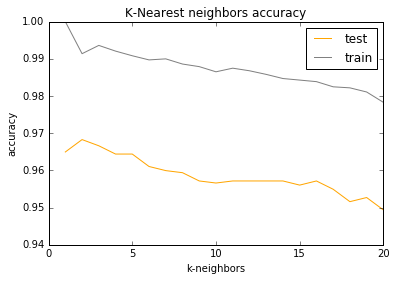

In [7]:
plt.plot(n_neigh, err_test, color = 'orange', label = 'test')
plt.plot(n_neigh, err_train, color = 'grey', label = 'train')
plt.legend()
plt.xlabel('k-neighbors')
plt.ylabel('accuracy')
plt.title('K-Nearest neighbors accuracy')
plt.show()

In [8]:
print('Highest accuracy {:.3f} at k={}'.format(
    max(err_test),n_neigh[err_test.index(max(err_test))]))

Highest accuracy 0.968 at k=2


With k-nearest neighbors the accuracy is actually pretty good. Let's compare the result with MLPClassifier.

## Neural network

Let's use MLPClasifier model from sklearn library. We'll check how it performs with different parameters. First, we'll use one layer with different numbers of neurons, next, we'll increase the number of layers to 2 and 3.

### One layer

In [9]:
activation = 'relu'

In [10]:
from sklearn.neural_network import MLPClassifier
neurons = [1,2,4,8,16,32,64, 128]

err_test1 = []
err_train1 = []

t = time.time()

for n in neurons:
    result = test(MLPClassifier,
     hidden_layer_sizes=(n, ),
     activation=activation,
     max_iter=50)
    err_test1.append(result[0])
    err_train1.append(result[1])
    
print("--- {:.3f} seconds ---".format(time.time() - t))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



--- 153.385 seconds ---


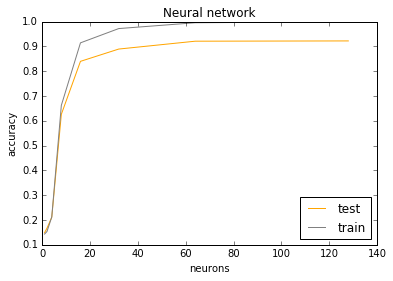

In [11]:
plt.plot(neurons, err_test1, color = 'orange', label = 'test')
plt.plot(neurons, err_train1, color = 'grey', label = 'train')
plt.legend(loc = 'lower right')
plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Neural network')
plt.show()

In [12]:
print('Highest accuracy {:.3f} at k={}'.format(
    max(err_test1),neurons[err_test1.index(max(err_test1))]))

Highest accuracy 0.922 at k=128


In [13]:
print(*list(zip(neurons, err_test1, err_train1))[-3:], sep = '\n')

(32, 0.8892943361188486, 0.9718961327057702)
(64, 0.9209811203961621, 0.9954088402763059)
(128, 0.9220999690498297, 0.9993043961351255)


With the increase of the number of neurons, the accuracy rose as well.

Overall, we see that k-nearest neighbors produced higher accuracy than one-layered neural network. Let's increase the number of layers.

### Two layers

In [14]:
neurons2 = [(32,32),(32,64), (64,32), (64,64)]

err_test2 = []
err_train2 = []

t = time.time()

for n in neurons2:
    result = test(MLPClassifier,
     hidden_layer_sizes=n,
     activation=activation,
     max_iter=50)
    err_test2.append(result[0])
    err_train2.append(result[1])
print("--- {:.3f} seconds ---".format(time.time() - t))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



--- 212.083 seconds ---


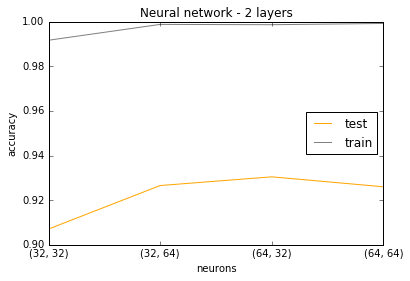

In [15]:
plt.plot(err_test2, color = 'orange', label = 'test')
plt.plot(err_train2, color = 'grey', label = 'train')
plt.legend(loc = 'center right')
plt.xticks(range(len(neurons2)), [str(i) for i in neurons2])
plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Neural network - 2 layers')
plt.show()

In [16]:
print('Highest accuracy {:.3f} at k={}'.format(
    max(err_test2),neurons2[err_test2.index(max(err_test2))]))

Highest accuracy 0.930 at k=(64, 32)


We see that the increase of the nuber of layers pisitively affected the accuracy of classification. The margin of improvement is not that big, however.

### Three layers

In [17]:
neurons3 = [(8,8,8),(16,16,16),(32,32,32),(64,64, 64)]

err_test3 = []
err_train3 = []

t = time.time()

for n in neurons3:
    result = test(MLPClassifier,
     hidden_layer_sizes=n,
     activation=activation,
     max_iter=50)
    err_test3.append(result[0])
    err_train3.append(result[1])
print("--- {:.3f} seconds ---".format(time.time() - t))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



--- 127.669 seconds ---


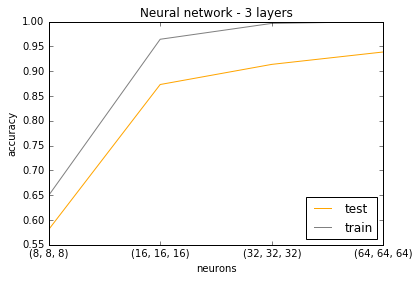

In [18]:
plt.plot(err_test3, color = 'orange', label = 'test')
plt.plot(err_train3, color = 'grey', label = 'train')
plt.legend(loc = 'lower right')
plt.xticks(range(len(neurons3)), [str(i) for i in neurons3])
plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Neural network - 3 layers')
plt.show()

In [19]:
print('Highest accuracy {:.3f} at k={}'.format(
    max(err_test3),neurons3[err_test3.index(max(err_test3))]))

Highest accuracy 0.939 at k=(64, 64, 64)


We see some slight improvement. Still, it is not as accurate at k-nearest neighbors model. Let's compare it to the random forest model.

## Random forest

Let's use a random forest model with the number of estimators = 50. We'll vary min_samples_leaf parameter of the model to see how it affects the result

In [20]:
from sklearn.ensemble import RandomForestClassifier

min_samples_leaf = range(1,33)
n_estimators=50

err_test4 = []
err_train4 = []

t = time.time()

for n in min_samples_leaf:
    result = test(RandomForestClassifier,
     min_samples_leaf=n,
     n_estimators=n_estimators)
    err_test4.append(result[0])
    err_train4.append(result[1])
print("--- {:.3f} seconds ---".format(time.time() - t))

--- 31.855 seconds ---


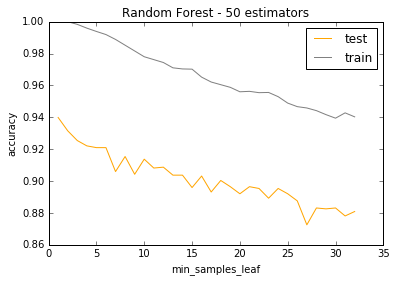

In [21]:
plt.plot(min_samples_leaf,err_test4,
         color = 'orange', label = 'test')
plt.plot(min_samples_leaf, err_train4,
         color = 'grey', label = 'train')
plt.legend(loc = 'upper right')
plt.xlabel('min_samples_leaf')
plt.ylabel('accuracy')
plt.title('Random Forest - {} estimators'.format(n_estimators))
plt.show()

In [23]:
print('Highest accuracy {:.3f} at k={}'.format(
    max(err_test4),min_samples_leaf[err_test4.index(max(err_test4))]))

Highest accuracy 0.940 at k=1


We see that the model provides a bit higher result than the highest we obtained in the neural network with 3 hidden layers. The computation was faster as well. Still, we see lower accuracy than the one of k-nearest neighbors model.

## Conclusion

Overall, the k-nearest neighbors model handled this classification problem better then the others. 

The second highest performance was obtained with a random forest and a neural network with 3 hidden layers. The speed of computation of the first model was much faster then the second. The accuracy was at relatively same level.

Some directions for the future assessment of models:

1. Look at how different activation functions in neural networks change performance. Not shown here, but already checked - logistic function will provide a bit higher accuracy, still not higher than the k-nearest neighbors.
2. Check how to visualize weights in neural network models, e.g. [visualization of MLP Weights on MNIST](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html).